# Table of Contents

# 0. Part 0 - Libraries

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# Usual librairy
from nucleo import *


# Necessary ones here
import matplotlib.pyplot as plt
import polars as pl
import csv

# Specific to this pinepline
from looping_model import *
# import importlib
# importlib.reload(looping_model)


# I. Part A - Functions

In [46]:
# --- Calculation functions --- #


def sum_by_shifted_chunks(data: np.ndarray, chunk_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the sum of elements in an array over non-overlapping chunks,
    starting at chunk_size/2, and return both the summed values and the 
    central positions of these chunks.

    Args:
        data (np.ndarray): Input array.
        chunk_size (int): Size of each chunk.

    Returns:
        Tuple[np.ndarray, np.ndarray]:
            - centers (np.ndarray): Array of middle indices for each chunk.
            - summed_values (np.ndarray): Array of summed values per chunk.
    """

    # Start chunks at chunk_size/2
    indices = np.arange(chunk_size // 2, len(data), chunk_size)

    # Compute the sum of values per chunk
    summed_values = np.add.reduceat(data, indices)
    # summed_values /= chunk_size

    # Compute the centers of the chunks
    centers = indices + (chunk_size // 2)

    # Adjust the last center if it exceeds array bounds
    centers[-1] = min(centers[-1], len(data) - 1)

    # Normalizing
    summed_values /= np.nansum(summed_values)

    return centers, summed_values


def find_median(data: np.ndarray, points: np.ndarray):
    """
    Compute the median value of a probability distribution.

    This function calculates the median of a given probability distribution `P`
    by identifying the point where the cumulative sum of `P` reaches 50% of its 
    total sum.

    Args:
        P (np.ndarray): Probability distribution array. Each element represents 
            the probability of a corresponding value in `points`.
        points (np.ndarray): Array of values corresponding to the probability 
            distribution `P`. The median is selected from this array.

    Returns:
        float: The median value, which corresponds to the point where the 
            cumulative probability reaches 50%.

    Notes:
        - The function first computes the cumulative sum of `P` using `np.cumsum`.
        - `np.searchsorted` is used to efficiently find the index where the 
          cumulative probability reaches half of the total sum.
        - It assumes `P` is properly normalized (i.e., sums to 1), but still 
          uses `np.sum(P) / 2` for robustness.
    """

    data /= np.nansum(data)
    cumsum = np.cumsum(data)
    index = np.searchsorted(cumsum, 0.5)
    median = points[index]
    return median


# --- Probability functions --- #


def calculate_P(x_array, bp_step, t_array, Pzero, lp, Rc_min, Rc_max, F, Width, Theta, choice):
    """
    Compute the probability distributions P and Peq based on input parameters.

    This function calculates:
    1. `P`: The probability distribution computed using `Pjump`, which represents
       the transition probabilities of a system over given lengths and time steps.
    2. `Peq`: The equilibrium probability distribution computed using `Ploop_rosa`,
       which accounts for loop formation under given physical constraints.

    Args:
        x_array (np.ndarray): 1D array of lengths over which the probability is computed.
        t_array (np.ndarray): 1D array of time steps for probability evolution.
        Pzero (float): Initial probability value for `Pjump`.
        lp (float): Persistence length, representing the characteristic stiffness of the system.
        Rc_max (float): Maximum constraint radius.
        Rc_min (float): Minimum constraint radius.
        F (float): External force applied to the system.
        Width (float): Width of capture.
        Theta (float): Angle of capture.

    Returns:
        Tuple[np.ndarray, np.ndarray]:
            - Peq (np.ndarray): The equilibrium probability distribution normalized over `x_array`.
            - P (np.ndarray): The probability distribution matrix (shape: len(t_array) × len(x_array)),
              where each row corresponds to a probability distribution at a given time step.

    Notes:
        - The function normalizes both distributions:
          - `P` is normalized row-wise to ensure valid probability distributions at each time step.
          - `Peq` is globally normalized so that its sum equals 1.
        - The `Ploop_rosa` function is applied in parallel using `Pool().map()` to compute `Peq`
          efficiently.
    """

    if choice == 'sphere':
        # Compute the probability distribution P using Pjump based on Ploop_rosa
        P, Peq = Pjump(
                lengths=x_array, 
                time=t_array, 
                P0=Pzero, 
                lp=lp, 
                Rc=Rc_max, 
                Rmin=Rc_min, 
                f=F
        )

    if choice == 'camembert':
        # Compute the probability distribution P using Pjump_camembert based on Ploop_camembert
        P, Peq = Pjump_camembert(
                lengths=x_array, 
                time=t_array, 
                P0=Pzero, 
                lp=lp, 
                Rc=Rc_max, 
                Width=Width, 
                f=F,
                thetaf=Theta
        )

    if choice not in ('sphere', 'camembert'):
        print('No such configuration for choice')
        return None
    
    # # HEREEE
    # print("P without any modification =", P)
    # print("Peq without any modification =", Peq)

    # # Normalizing P
    # P_factor = np.nansum(P, axis=1, keepdims=True) * bp_step
    # P_factor[P_factor == 0] = np.nan
    # P /= P_factor
    # P = np.nan_to_num(P, nan=0.0)

    # Transpose to have one subarray per time step and normalize each row
    P = np.transpose(P)

    # # Normalizing Peq
    # Peq_factor = np.nansum(Peq) * bp_step
    # Peq /= Peq_factor
    return Peq, P


def proba_single_call(x_array, bp_step, t_array, Pzero, lp, Rc_min, Rc_max, F, Width, Theta, ryu_bin, choice):

    # Calculation of probabilities : Peq and P
    Peq, P = calculate_P(x_array, bp_step, t_array, Pzero, lp, Rc_min, Rc_max, F, Width, Theta, choice)

    # Calculation of summed Peq
    points, Peq_summed = sum_by_shifted_chunks(Peq, ryu_bin) 

    # Calculation of summed P
    P_summed = np.empty(len(t_array), dtype=object)
    for i in range(len(t_array)):
        _, P_summed[i] = sum_by_shifted_chunks(P[i], ryu_bin)

    # Medians
    medians = np.apply_along_axis(find_median, axis=1, arr=P, points=x_array)

    return (points, Peq, Peq_summed, P, P_summed, medians)


# --- Saving functions --- #


def safe_mkdir(folder_name: str):
    """
    Create a directory if it does not already exist,
    and only if the current working directory is not already the target directory.

    This prevents accidentally creating nested folders with the same name.
    """
    abs_target = os.path.abspath(folder_name)
    abs_cwd = os.path.abspath(os.getcwd())

    if abs_target != abs_cwd and not os.path.exists(abs_target):
        os.makedirs(abs_target)


def save_probas_to_parquet(
    P_points, Peq, Peq_summed, P, P_summed, medians,
    choice, lp, Rc_min, Rc_max, F_nm, Width, Theta, conversion,
    folder_name="probas_datas"
):
    """
    Save the output of a single call to the probability function into a compressed Parquet file.

    The filename is constructed from the key input parameters, and the data is stored inside
    the given folder using the `writing_parquet` function (which must not be modified).

    Args:
        P_points, Peq, Peq_summed, P, P_summed, medians: Arrays or lists representing the output data.
        choice (str): The simulation choice (e.g., 'sphere').
        lp, Rc_min, Rc_max, F_bp, width, conversion: Numerical parameters of the simulation.
        folder_name (str): Name of the output directory (default: "probas_datas").
    """
    safe_mkdir(folder_name)

    base_name = f"{choice}_lp{lp}_RcMin{Rc_min}_RcMax{Rc_max}_Fnm{F_nm}_Width{Width}_Theta{Theta}_conv{conversion}"

    data = {
        "P_points": P_points,
        "Peq": Peq,
        "Peq_summed": Peq_summed,
        "P": P,
        "P_summed": P_summed,
        "medians": medians
    }

    writing_parquet(file=base_name, title=folder_name, data_result=data)

    # print(f"Results saved to: {os.path.join(folder_name, f'{base_name}_{folder_name}.parquet')}")


def read_probas_from_parquet(
    choice, lp, Rc_min, Rc_max, F_nm, Width, Theta, conversion,
    folder_name="/home/nicolas/Documents/Progs/probas_datas"
):
    """
    Load a Parquet file generated by `save_probas_to_parquet` and return it as a Polars DataFrame.

    The filename is reconstructed from the input parameters and the folder name.

    Args:
        choice (str): Simulation type identifier (e.g., 'sphere').
        lp, Rc_min, Rc_max, F_bp, width, conversion: Simulation parameters used in the filename.
        folder_name (str): Path to the directory containing the Parquet files.

    Returns:
        pl.DataFrame: The loaded data in Polars format.

    Raises:
        FileNotFoundError: If the specified Parquet file does not exist.
    """
    base_name = f"{choice}_lp{lp}_RcMin{Rc_min}_RcMax{Rc_max}_Fnm{F_nm}_Width{Width}_Theta{Theta}_conv{conversion}"
    full_path = os.path.join(folder_name, f"{base_name}_{os.path.basename(folder_name)}.parquet")

    if not os.path.isfile(full_path):
        raise FileNotFoundError(f"File not found: {full_path}")

    df_polars = pl.read_parquet(full_path)
    pl.Config.set_tbl_cols(len(df_polars.columns))

    return df_polars


# --- Data functions --- #


def plot_one_call(F_nm, Rc, ryu_x, ryu_y, x_array, Peq, P_points, Peq_summed, P, P_summed, t_array, x_max, scale ='log', ax=None):
    """
    Plots Ryu data, Peq, and P distributions in a log-log graph.

    Parameters:
    - F_bp (float): Force in Newtons.
    - conversion (float): Base pair per nanometer conversion factor.
    - ryu_bin (float): Bin size for Ryu data.
    - ryu_x (array-like): X-coordinates of Ryu data.
    - ryu_y (array-like): Y-coordinates of Ryu data.
    - x_array (array-like): X-coordinates for Peq and P distributions.
    - Peq (array-like): Equilibrium probability distribution.
    - P_points (array-like): X-coordinates for binned Peq values.
    - Peq_summed (array-like): Binned Peq values.
    - P (list of array-like): List of P distributions at different time steps.
    - P_summed (list of array-like): List of binned P distributions.
    - t_array (array-like): Time values corresponding to each P distribution.
    - x_max (float): Upper limit for the X-axis.
    - ax (matplotlib.axes.Axes, optional): Existing axis to plot on. If None, a new figure is created.

    Returns:
    - matplotlib.axes.Axes: The axis with the plotted data.
    """

    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))
    
    ax.set_title(f'F={F_nm}N - Rc={Rc}bp')

    # Ryu data
    ax.plot(ryu_x, ryu_y, marker='o', label='Ryu data', ls='-', color='k', markeredgecolor='black')

    # # Checking sums
    print('sum of datas =', np.sum(ryu_y))
    print('sum of P[0] =', np.sum(P[0]))
    print('sum of P_summed[0] =', np.sum(P_summed[0]))

    # Peq
    line, = ax.plot(x_array, Peq, marker='+', label='Peq', ls='--')
    color = line.get_color()
    ax.plot(P_points, Peq_summed, marker='o', label='Peq binned', ls='-', color=color, markeredgecolor='black')

    # P distributions
    for i in range(len(P)):
        line, = ax.plot(x_array, P[i], marker='+', label=f'P at t={t_array[i]}', ls='--')
        color = line.get_color()
        ax.plot(P_points, P_summed[i], marker='o', label=f'P_binned at t={t_array[i]}', ls='-', color=color, markeredgecolor='black')

    # Axes and display settings
    ax.grid(True, which='both')
    ax.set_xlim(1e0, 2*x_max)
    ax.set_ylim(1e-15, 1e0)
    if scale == 'log':
        ax.set_xscale("log")
        ax.set_yscale("log")
    ax.legend(fontsize=7, loc='lower left')

    return ax


def getting_datas(choice, lp, Rc_min, Rc_max, F_nm, Width, Theta, conversion, x_array, t_array, x_max, ryu_x, ryu_y, plot_option=True, return_option=True):
    """
    Load probability data from a Parquet file and visualize the result.

    This function:
    1. Loads the dataset corresponding to the given simulation parameters.
    2. Extracts relevant arrays (Peq, P_points, etc.) from the Polars DataFrame.
    3. Calls `plot_one_call()` to display a probability visualization.
    4. Displays the resulting plot.

    Args:
        choice (str): Type of configuration (e.g. "sphere").
        lp (float): Persistence length.
        Rc_min (float): Minimum constraint radius.
        Rc_max (float): Maximum constraint radius.
        F_bp (float): Applied force in base pair units.
        width (float): Width of the constraint or potential.
        conversion (float): Conversion factor from base pairs to meters.

    Returns:
        None
    """
    # Read data from Parquet file
    df = read_probas_from_parquet(choice, lp, Rc_min, Rc_max, F_nm, Width, Theta, conversion)

    # Extract data from the DataFrame
    Peq = df["Peq"].to_numpy()[0]
    P_points = df["P_points"].to_numpy()[0]
    Peq_summed = df["Peq_summed"].to_numpy()[0]
    P = df["P"].to_numpy()[0]
    P_summed = df["P_summed"].to_numpy()[0]
    medians = df["medians"].to_numpy()[0]

    # Plot the results
    if plot_option:
        plot_one_call(F_nm, Rc_max, ryu_x, ryu_y, x_array, Peq, P_points, Peq_summed, P, P_summed, t_array, x_max, 'log')
        plt.show()

    # print(Peq)
    # print(len(Peq))
    
    # Return results
    if return_option:
        return Peq, P_points, Peq_summed, P, P_summed, medians


# --- Call functions --- #


def run_probas(
    x_array,
    bp_step,
    t_array,
    Pzero,
    lp,
    Rc_min,
    Rc_max,
    F_bp,
    F_nm,
    Width,
    Theta,
    ryu_bin,
    choice,
    conversion,
    folder_name="probas_datas"
):
    """
    Run a single probability computation and save the results to a Parquet file.

    This function performs the following steps:
    1. Calls `proba_single_call()` using the given simulation and system parameters.
    2. Prints the resulting medians to the console.
    3. Saves all computed arrays to a Parquet file using `save_probas_to_parquet()`.

    Args:
        x_array (array-like): Spatial positions for the computation.
        bp_step (float): Step size in base pairs.
        t_array (array-like): Time array or time steps.
        Pzero (array-like): Initial probability distribution.
        lp (float): Persistence length.
        Rc_min (float): Minimum radius constraint.
        Rc_max (float): Maximum radius constraint.
        F_bp (float): Force applied in base pair units.
        width (float): Width parameter for potential or constraint.
        ryu_bin (array-like): Discretized binning structure.
        choice (str): Configuration identifier (e.g. "sphere").
        conversion (float): Conversion factor for base pairs to meters.
        folder_name (str, optional): Output folder where the Parquet file will be saved.

    Returns:
        None
    """
    # # Announce
    # print(f"Launched for: choice={choice}, lp={lp}, Rc=({Rc_min}-{Rc_max}), width={width}, F_bp={F_bp}, conversion={conversion}")

    # Run probability calculations
    P_points, Peq, Peq_summed, P, P_summed, medians = proba_single_call(
        x_array, bp_step, t_array, Pzero,
        lp, Rc_min, Rc_max, F_bp, Width, Theta, 
        ryu_bin, choice
    )



    # Save outputs to file
    save_probas_to_parquet(
        P_points, Peq, Peq_summed, P, P_summed, medians,
        choice, lp, Rc_min, Rc_max, F_nm, Width, Theta, 
        conversion,
        folder_name=folder_name
    )


def launch_all_probas_and_plot(
    lp_ndna_array,
    Rc_min_array,
    Rc_max_array,
    F_bp_array,
    Width_array,
    Theta_array,
    choice_array,
    bp_per_m_array,
    F_nm_array,
    x_array,
    bp_step,
    t_array,
    Pzero,
    ryu_bin,
    ryu_x,
    ryu_y,
    x_max,
    output_csv="all_medians.csv"
):
    """
    Run `run_probas()` over all combinations of `choice`, `Rc_max`, and `F_bp`,
    plot all results and save the full figure. Also writes a CSV containing all median
    values for each parameter combination.

    Args: (see previous docstring)

    Returns:
        None (writes the CSV to disk)
    """
    lp = lp_ndna_array[0]
    Rc_min = Rc_min_array[0]
    Width = Width_array[0]
    Theta = Theta_array[0]

    nrows = len(Rc_max_array)
    ncols = len(F_bp_array) * len(choice_array)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))

    if nrows == 1 or ncols == 1:
        axes = np.array(axes, dtype=object).reshape(nrows, ncols)

    total = len(choice_array) * len(Rc_max_array) * len(F_bp_array)
    pbar = tqdm(total=total, desc="Running simulations")

    # CSV rows: header first
    csv_rows = []
    header = ["choice", "Rc_max", "F_bp"] + [f"median_t{t}" for t in t_array]
    csv_rows.append(header)

    for k, choice in enumerate(choice_array):
        for i, Rc_max in enumerate(Rc_max_array):
            for j, F_bp in enumerate(F_bp_array):
                ax = axes[i, j + k * len(F_bp_array)]
                conversion = bp_per_m_array[j]
                F_nm = F_nm_array[j]
                
                run_probas(
                    x_array, bp_step, t_array, Pzero,
                    lp, Rc_min, Rc_max, F_bp, F_nm, Width, Theta,
                    ryu_bin, choice, conversion
                )

                Peq, P_points, Peq_summed, P, P_summed, medians = getting_datas(
                    choice, lp, Rc_min, Rc_max, F_nm, Width, Theta,
                    conversion, x_array, t_array, x_max,
                    ryu_x, ryu_y, 
                    plot_option=False, return_option=True
                )

                # Append to CSV data
                row = [choice, Rc_max, F_bp] + list(medians)
                csv_rows.append(row)

                plot_one_call(
                    F_nm, Rc_max,
                    ryu_x, ryu_y, x_array,
                    Peq, P_points, Peq_summed, P, P_summed,
                    t_array, x_max, ax=ax
                )
                ax.set_title(f"{choice}\nRc={Rc_max}bp | F={F_nm_array[j]*1e12:.1f}pN")
                pbar.update(1)

    pbar.close()
    plt.tight_layout()
    plt.savefig("all_probas_results_theta_pi.png", dpi=300)
    print("All datas saved to 'probas_datas'")
    print("All plots saved to 'all_probas_results.png'")

    # Write CSV
    with open(output_csv, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(csv_rows)

    print(f"Medians saved to '{output_csv}'")


# --- Medians functions --- #


def read_medians_csv(csv_path="all_medians.csv"):
    """
    Load the CSV file containing median values into a Polars DataFrame.

    Args:
        csv_path (str): Path to the CSV file (default: 'all_medians.csv').

    Returns:
        pl.DataFrame: The loaded DataFrame with columns:
            - 'choice' (str)
            - 'Rc_max' (int or float)
            - 'F_bp' (float)
            - 'median_tX' (float) for each time step
    """
    try:
        df = pl.read_csv(csv_path)
        pl.Config.set_tbl_cols(len(df.columns))  # Show all columns if printing
        print(f"CSV loaded successfully from: {csv_path}")
        return df
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return None


def plot_medians_from_df(df_medians, t_array, Rc_max_array, F_bp_array, F_nm_array, ryu_medians=None, choice_filter="camembert"):
    """
    Generate plots from a filtered medians dataframe for a given `choice`.

    Parameters:
        df_medians (pl.DataFrame): The dataframe read from 'all_medians.csv'.
        t_array (np.ndarray): Array of time points.
        Rc_max_array (np.ndarray): Array of Rc_max values.
        F_bp_array (np.ndarray): Array of force values in bp units.
        F_nm_array (np.ndarray): Array of force values in Newtons.
        ryu_medians (np.ndarray): Optional reference medians to compare against.
        choice_filter (str): Filter to select one configuration (e.g., "sphere").
    """
    import pandas as pd
    if isinstance(df_medians, pl.DataFrame):
        df_medians = df_medians.to_pandas()

    # Filter only for the given choice
    df = df_medians[df_medians["choice"] == choice_filter]

    # First plot: medians vs t for each (Rc_max, F_bp)
    nrows, ncols = len(Rc_max_array), len(F_bp_array)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
    axes = np.array(axes).reshape(nrows, ncols)

    for i, Rc in enumerate(Rc_max_array):
        for j, F_bp in enumerate(F_bp_array):
            subset = df[(df["Rc_max"] == Rc) & (df["F_bp"].round(6) == round(F_bp, 6))]
            if subset.empty:
                continue
            medians = subset.iloc[0, 3:].to_numpy()
            ax = axes[i, j]
            ax.set_title(f'Rc={Rc} bp | F={F_nm_array[j]*1e12:.2f} pN')
            ax.plot(t_array, medians, marker='o', linestyle='-', label='medians')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.grid(True, which='both')
            ax.set_xlabel('t')
            ax.set_ylabel('Median (bp)')

    plt.tight_layout()
    plt.show()

    # Second plot: median vs Force for each t
    fig, axes = plt.subplots(1, len(t_array), figsize=(5 * len(t_array), 5))
    if len(t_array) == 1:
        axes = [axes]

    for idx, t in enumerate(t_array):
        ax = axes[idx]
        ax.set_title(f't={t}')
        if ryu_medians is not None:
            ax.plot(F_nm_array[1:], ryu_medians, marker='o', color='k', label='ryu medians')

        for i, Rc in enumerate(Rc_max_array):
            subset = df[df["Rc_max"] == Rc].sort_values(by="F_bp")
            if len(subset) != len(F_nm_array):
                continue
            y_vals = subset.iloc[:, 3 + idx].to_numpy()
            ax.plot(F_nm_array, y_vals, marker='o', linestyle='--', label=f'Rc={Rc} bp')

        ax.set_xlabel("Force (N)")
        ax.set_ylabel("Median (bp)")
        ax.grid(True, which='both')
        ax.legend()

    plt.tight_layout()
    plt.show()

    # Third plot: median vs Force for each Rc
    fig, axes = plt.subplots(1, len(Rc_max_array), figsize=(5 * len(Rc_max_array), 5))
    if len(Rc_max_array) == 1:
        axes = [axes]

    for idx, Rc in enumerate(Rc_max_array):
        ax = axes[idx]
        ax.set_title(f'Rc={Rc}')
        if ryu_medians is not None:
            ax.plot(F_nm_array[1:], ryu_medians, marker='o', color='k', label='ryu medians')

        subset = df[df["Rc_max"] == Rc].sort_values(by="F_bp")
        if len(subset) != len(F_nm_array):
            continue
        for i, t in enumerate(t_array):
            y_vals = subset.iloc[:, 3 + i].to_numpy()
            ax.plot(F_nm_array, y_vals, marker='o', linestyle='--', label=f't={t}')

        ax.set_xlabel("Force (N)")
        ax.set_ylabel("Median (bp)")
        ax.grid(True, which='both')
        ax.legend()

    plt.tight_layout()
    plt.show()


# --- Ryu functions --- #


def convert_step_size_and_normalize(df: pl.DataFrame, conversion_factor: float = 0.246):
    """
    Converts step sizes from nm to bp and normalizes count data into probabilities.

    Parameters:
    - df (pl.DataFrame): Input data with 'Step size (nm)' and 'Count' columns.
    - conversion_factor (float): nm-to-bp conversion factor.

    Returns:
    - tuple: Arrays for x (nm), x (bp), y (counts), and y (normalized probabilities).
    """
    x_nm = df['Step size (nm)'].to_numpy()
    y_count = df['Count'].to_numpy()
    x_bp = x_nm / conversion_factor
    y_proba = y_count / np.sum(y_count)
    return x_nm, x_bp, y_count, y_proba


def truncate_and_normalize_positive_bp(x_bp: np.ndarray, y_proba: np.ndarray):
    """
    Keeps only the positive values of the step size (in bp) and renormalizes the probabilities.

    Parameters:
    - x_bp (np.ndarray): Step sizes in base pairs.
    - y_proba (np.ndarray): Normalized probabilities.

    Returns:
    - tuple: Arrays for positive x_bp and normalized y_proba.
    """
    mask = x_bp <= 0
    x = -x_bp[mask][::-1]
    y = y_proba[mask][::-1]
    y /= np.sum(y)
    return x, y


def plot_ryu_distributions(x_nm, x_bp, y_count, y_proba, ryu_x, ryu_y):
    """
    Plots the Ryu data across four subplots.

    Parameters:
    - x_nm (np.ndarray): Step sizes in nm.
    - x_bp (np.ndarray): Step sizes in bp.
    - y_count (np.ndarray): Raw counts.
    - y_proba (np.ndarray): Normalized probabilities.
    - ryu_x (np.ndarray): Truncated positive step sizes.
    - ryu_y (np.ndarray): Truncated and renormalized probabilities.
    """
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
    plt.suptitle('Fig 3B')

    ax1.set_title('Counts per nm')
    ax1.plot(x_nm, y_count, marker='+', c='b')
    ax1.set_xlabel('Step size (nm)')
    ax1.set_ylabel('Count')
    ax1.grid(True)

    ax2.set_title('Normalized probability per bp')
    ax2.plot(x_bp, y_proba, marker='+', c='b')
    ax2.set_xlabel('Step size (bp)')
    ax2.set_ylabel('Distribution')
    ax2.grid(True)

    for ax in [ax3, ax4]:
        ax.set_title('Truncated proba per bp (>0)')
        ax.plot(ryu_x, ryu_y, marker='o', c='k')
        ax.set_xlabel('Step size (bp)')
        ax.set_ylabel('Distribution')
        ax.grid(True)

    ax4.loglog()
    plt.tight_layout()
    plt.show()


def compute_ryu_bin_width(ryu_x: np.ndarray):
    """
    Computes the bin width from the truncated step sizes.

    Parameters:
    - ryu_x (np.ndarray): Truncated step sizes.

    Returns:
    - int: Bin width (rounded).
    """
    return int(np.round(np.diff(ryu_x)[0]))


def read_and_process_medians(df: pl.DataFrame, conversion_factor: float = 0.246):
    """
    Processes the median step size values from the Ryu Excel sheet.

    Parameters:
    - df (pl.DataFrame): Sheet containing different force conditions.

    Returns:
    - list: List of medians per force column.
    """
    df = df.slice(1)
    df = df.rename({
        "__UNNAMED__0": "Step size (nm)",
        "Count": "F = 1 pN",
        "__UNNAMED__2": "F = 0.7 pN",
        "__UNNAMED__3": "F = 0.6 pN",
        "__UNNAMED__4": "F = 0.5 pN",
        "__UNNAMED__5": "F = 0.4 pN",
        "__UNNAMED__6": "F = 0.3 pN",
        "__UNNAMED__7": "F = 0.2 pN",
    })

    F_points = df["Step size (nm)"].cast(pl.Float64).to_numpy().copy() / conversion_factor
    medians = []
    for col in df.columns[1:]:
        values = df[col].cast(pl.Float64).to_numpy().copy()  # <-- COPY HERE
        values /= np.sum(values)
        median = find_median(proba=values, points=F_points)
        medians.append(median)
    return medians


def slice_first_row(df: pl.DataFrame) -> pl.DataFrame:
    """Remove the first row of the dataframe."""
    return df.slice(1)


def rename_columns(df: pl.DataFrame) -> pl.DataFrame:
    """Rename columns to meaningful force labels."""
    return df.rename({
        "__UNNAMED__0": "Step size (nm)",
        "Count": "F = 1 pN",
        "__UNNAMED__2": "F = 0.7 pN",
        "__UNNAMED__3": "F = 0.6 pN",
        "__UNNAMED__4": "F = 0.5 pN",
        "__UNNAMED__5": "F = 0.4 pN",
        "__UNNAMED__6": "F = 0.3 pN",
        "__UNNAMED__7": "F = 0.2 pN",
    })


def cast_columns_to_float(df: pl.DataFrame) -> pl.DataFrame:
    """Cast all columns (except 'Step size (nm)') to Float64."""
    for col in df.columns:
        if col != "Step size (nm)":
            df = df.with_columns(pl.col(col).cast(pl.Float64))
    df = df.with_columns(pl.col("Step size (nm)").cast(pl.Float64))
    return df


def reorder_columns(df: pl.DataFrame) -> pl.DataFrame:
    """Reorder columns so that smaller forces come first."""
    new_order = [
        "Step size (nm)",
        "F = 0.2 pN",
        "F = 0.3 pN",
        "F = 0.4 pN",
        "F = 0.5 pN",
        "F = 0.6 pN",
        "F = 0.7 pN",
        "F = 1 pN",
    ]
    return df.select(new_order)


def keep_and_flip_negatives(df: pl.DataFrame, column_name: str = "Step size (nm)") -> pl.DataFrame:
    """Keep only non-positive values and flip signs to positive."""
    df_filtered = df.filter(pl.col(column_name) <= 0)
    df_flipped = df_filtered.with_columns(
        (-pl.col(column_name)).alias(column_name)
    )
    return df_flipped


def organizing_ryu_data_frame(df: pl.DataFrame, only_forward=True) -> pl.DataFrame:
    """
    Full pipeline: slice, rename, cast, reorder, filter negatives, and flip signs.

    Args:
        df (pl.DataFrame): Raw Ryu input dataframe.

    Returns:
        pl.DataFrame: Cleaned and prepared dataframe.
    """
    df = slice_first_row(df)
    df = rename_columns(df)
    df = cast_columns_to_float(df)
    df = reorder_columns(df)
    if only_forward:
        df = keep_and_flip_negatives(df)
    return df


def find_medians_in_a_data_frame(df: pl.DataFrame, force_to_conversion: dict):
    """
    Processes the median step size values from the Ryu Excel sheet.

    Parameters:
    - df (pl.DataFrame): Sheet containing different force conditions.
    - force_to_conversion (dict): Dictionary mapping force columns to conversion factors.

    Returns:
    - np.ndarray: Array of medians per force column, already divided by correct conversion.
    """
    medians = []
    df_points = df["Step size (nm)"].cast(pl.Float64).to_numpy().copy()
    for col in df.columns[1:]:
        values = df[col].cast(pl.Float64).to_numpy().copy()
        median = find_median(data=values, points=df_points)
        median /= force_to_conversion[col]
        medians.append(median)

    return np.array(medians)

# II. Part B - Launches

## II.1 Inputs

In [47]:
# Chromatin fiber
x_max = 500 # 2_000 
bp_step = 1
x_min = 1
x_array = np.arange(x_min, x_max + bp_step, bp_step)
x_length = len(x_array)


# Times
# t_array = np.logspace(start=1, stop=6, num=6, dtype=int)
t_array = np.logspace(start=1, stop=7, num=4, dtype=int)
print(t_array)


# Model used
# choice_array = ["camembert", "sphere"]
choice_array = ["camembert"]


# Parameters in Base Pairs and Newtons
lp_ndna_array = np.array([170])
Rc_min_array = np.array([0])
Rc_max_array = np.array([70, 140, 210, 280])            # In base pairs
F_nm_array = np.array([
    0, 0.2e-12,                                         # In Newtons
    0.3e-12, 0.4e-12, 
    0.5e-12, 0.6e-12, 
    0.7e-12, 1e-12
])
Width_array = np.array([1])
# Theta_array = np.array([0])
Theta_array = np.array([np.pi])


# Pzero
Pzero = np.array([1] + [0] * (x_length - 1))


# Conversions
kb, T = 1.380649e-23, 300
bp_per_m_array = np.array([0.200e-9, 0.205e-9,          # Equivalent nm in bp from Ryu datas
                           0.231e-9, 0.246e-9, 
                           0.256e-9, 0.264e-9, 
                           0.269e-9, 0.286e-9])
F_bp_array = F_nm_array / (kb * T ) * bp_per_m_array    # Applying conversion for base pairs



# Environment 
os.chdir("/home/nicolas/Documents/Progs")


# Print
print("Parameters loaded")

[      10     1000   100000 10000000]
Parameters loaded


## II.2 Ryu - Datas

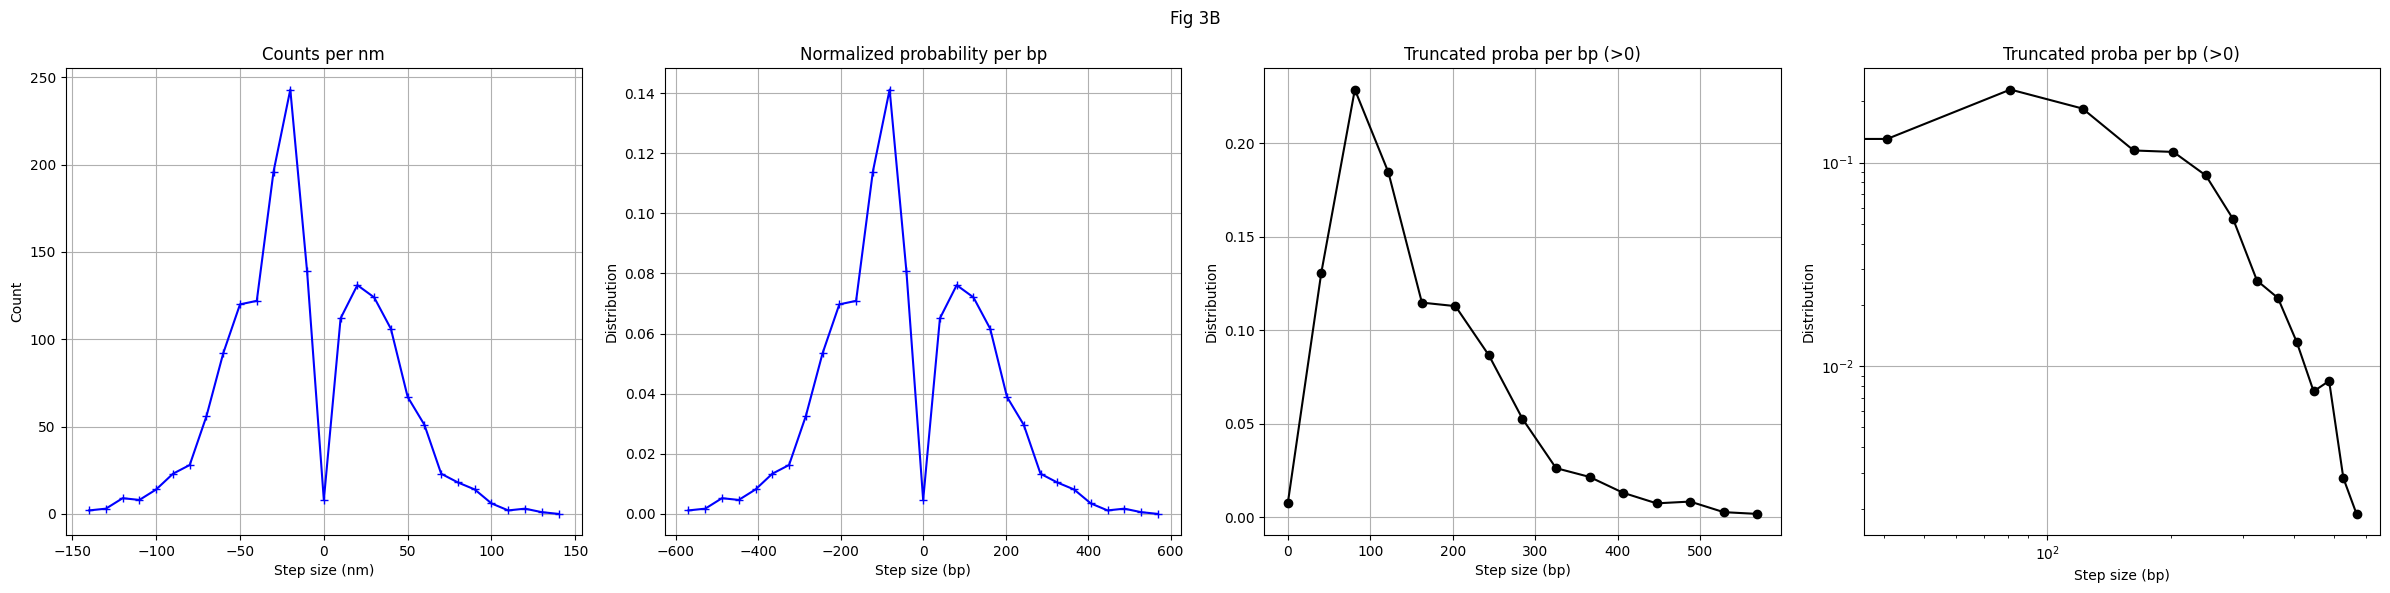

Bin width: 41

Medians found on xlsx:
 [195.12195122 129.87012987  81.30081301  78.125       75.75757576
  37.17472119  34.96503497]

Medians found on paper:
 [200 170 100 130 100  90  70]


In [48]:
# First line
df_one_force = pl.read_excel("/home/nicolas/Documents/Progs/ryu_datas.xlsx", sheet_name="Fig. 3B")
x_nm, x_bp, y_count, y_proba = convert_step_size_and_normalize(df_one_force)
ryu_x, ryu_y = truncate_and_normalize_positive_bp(x_bp, y_proba)
plot_ryu_distributions(x_nm, x_bp, y_count, y_proba, ryu_x, ryu_y)
ryu_bin = compute_ryu_bin_width(ryu_x)
print('Bin width:', ryu_bin)


# Second line
df_all_forces = pl.read_excel("/home/nicolas/Documents/Progs/ryu_datas.xlsx", sheet_name="Fig. 3E S5B")
df_clean = organizing_ryu_data_frame(df_all_forces)

force_to_conversion = {
    "F = 0.2 pN": 0.205,
    "F = 0.3 pN": 0.231,
    "F = 0.4 pN": 0.246,
    "F = 0.5 pN": 0.256,
    "F = 0.6 pN": 0.264,
    "F = 0.7 pN": 0.269,
    "F = 1 pN":   0.286,
}

medians = find_medians_in_a_data_frame(df_clean, force_to_conversion)
print('\nMedians found on xlsx:\n', medians)

ryu_medians = np.array([200,170,100,130,100,90,70])
print('\nMedians found on paper:\n', ryu_medians)

## II.3 One Call

In [49]:
# One call parameters
lp = lp_ndna_array[0]
Rc_max = Rc_max_array[2]
Rc_min = Rc_min_array[0]
Width = Width_array[0]
Theta = Theta_array[0]


# Specific to one launch
rank_test = 3
F_nm, conversion, F_bp = F_nm_array[rank_test], bp_per_m_array[rank_test], F_bp_array[rank_test]
choice_test = "camembert" # "sphere"


# Print
print("Ready to launch run_probas() with parameters:")
print(f"  lp          = {lp}")
print(f"  Rc_max      = {Rc_max}")
print(f"  Rc_min      = {Rc_min}")
print(f"  Width       = {Width}")
print(f"  Theta       = {Theta}")
print(f"  F_nm        = {F_nm}")
print(f"  conversion  = {conversion}")
print(f"  F_bp        = {F_bp}")
print(f"  choice_test = {choice_test}")

Ready to launch run_probas() with parameters:
  lp          = 170
  Rc_max      = 210
  Rc_min      = 0
  Width       = 1
  Theta       = 3.141592653589793
  F_nm        = 4e-13
  conversion  = 2.46e-10
  F_bp        = 0.023756943292610938
  choice_test = camembert


In [50]:
# One launch
run_probas(x_array, bp_step, t_array, Pzero, lp, Rc_min, Rc_max, F_bp, F_nm, Width, Theta, ryu_bin, choice_test, conversion)

sum of datas = 0.9999999999999998
sum of P[0] = 1.0000000000000002
sum of P_summed[0] = 1.0


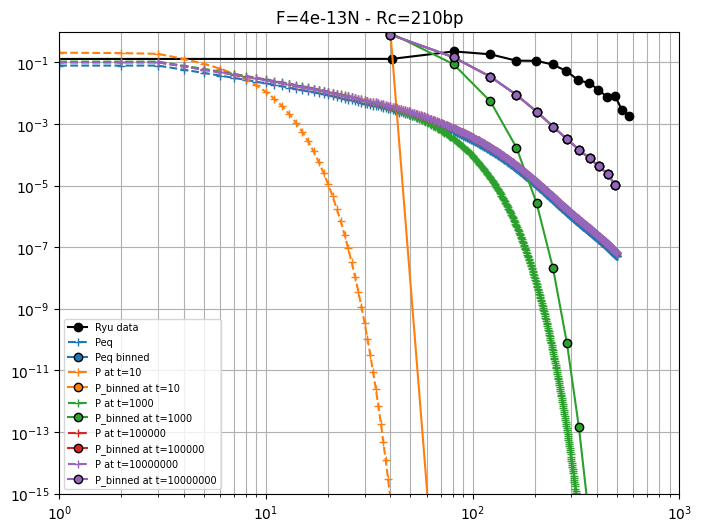

In [51]:
getting_datas(choice_test, lp, Rc_min, Rc_max, F_nm, Width, Theta, conversion, x_array, t_array, x_max, ryu_x, ryu_y, plot_option=True, return_option=False)

## II.4 Multi Calls : Sphere + Cylinder

Running simulations: 100%|██████████| 32/32 [8:08:26<00:00, 915.84s/it]   


/home/nicolas/Documents/Progs/looping_model.py:115: RuntimeWarning: overflow encountered in exp
  C = np.exp(-(d(kappa) * kappa * a * b * (1 + b) * r**2) / ((1 - b**2 * r**2) + EPS))
/home/nicolas/Documents/Progs/looping_model.py:118: RuntimeWarning: overflow encountered in multiply
  res = Jsyd(kappa) * A * B * C * Bessel0(D)
/home/nicolas/Documents/Progs/looping_model.py:118: RuntimeWarning: invalid value encountered in multiply
  res = Jsyd(kappa) * A * B * C * Bessel0(D)
/home/nicolas/Documents/Progs/looping_model.py:96: RuntimeWarning: invalid value encountered in scalar power
  A = ((1 - c(kappa) * r**2) / ((1 - r**2) + EPS)) ** 2.5
/home/nicolas/Documents/Progs/looping_model.py:369: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  res2, _ = quad(
/home/nicolas/Documents/Progs/looping_model.py:372: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  res3, _ = quad(
/

All datas saved to 'probas_datas'
All plots saved to 'all_probas_results.png'
Medians saved to 'all_medians.csv'


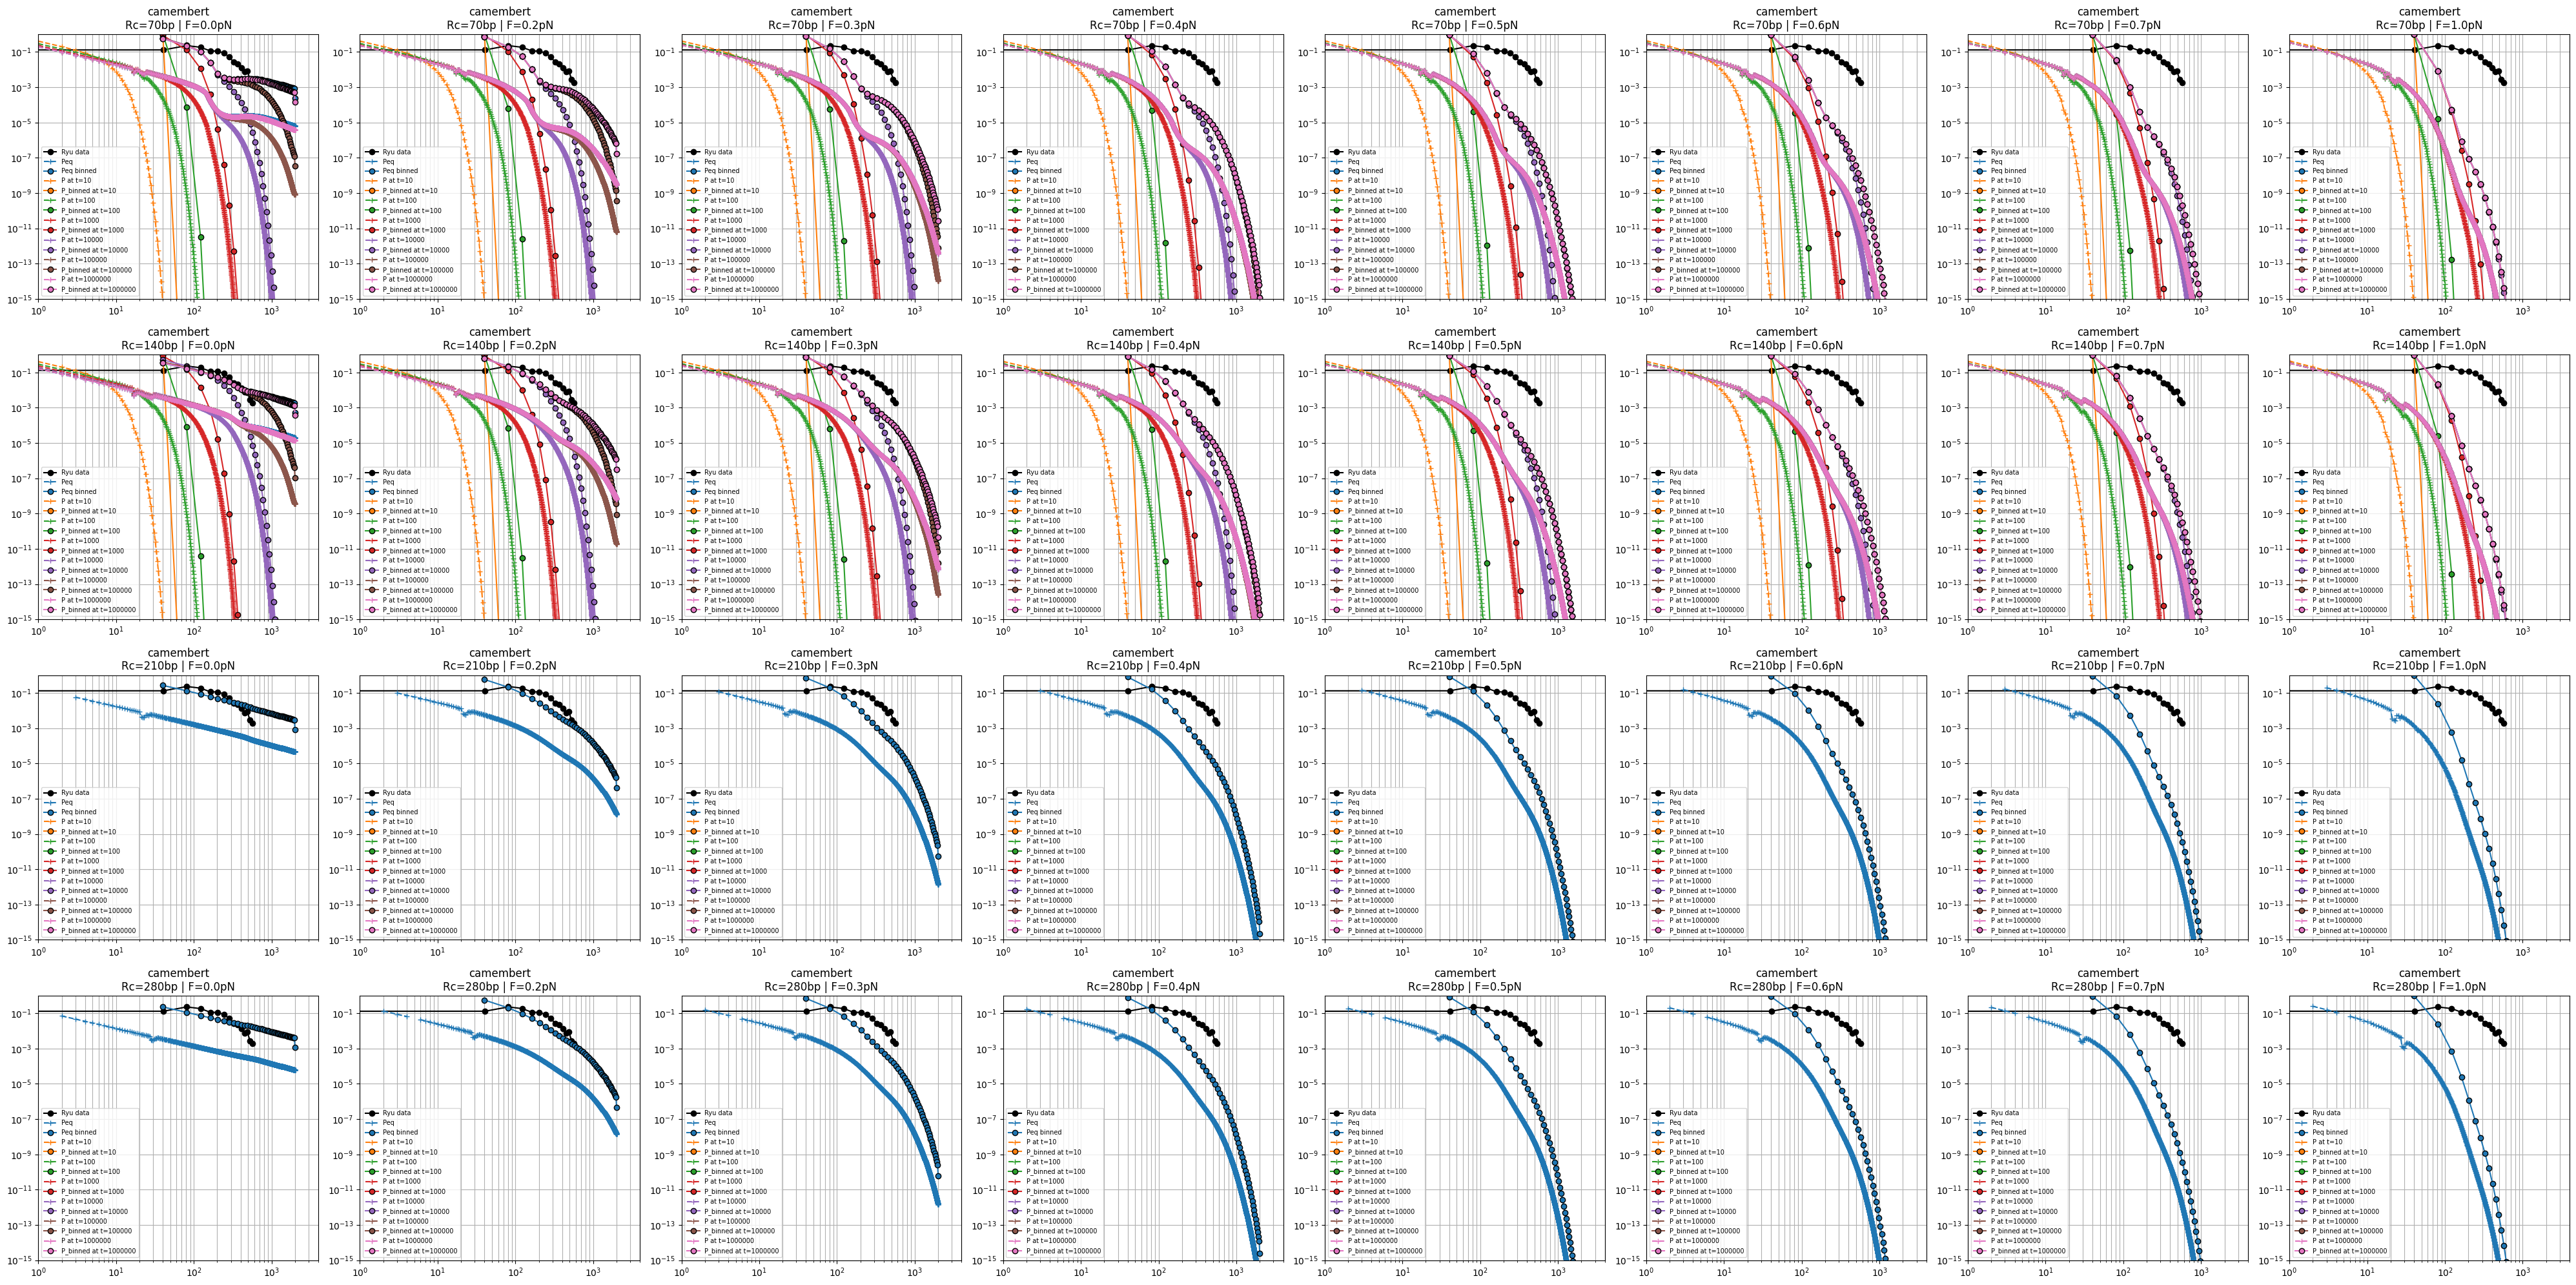

In [10]:
if __name__ == "__main__":
    launch_all_probas_and_plot(
    lp_ndna_array,
    Rc_min_array,
    Rc_max_array,
    F_bp_array,
    Width_array,
    Theta_array,
    choice_array,
    bp_per_m_array,
    F_nm_array,
    x_array,
    bp_step,
    t_array,
    Pzero,
    ryu_bin,
    ryu_x,
    ryu_y,
    x_max
)

## II.5 Multi Calls : Medians

CSV loaded successfully from: all_medians.csv
(32, 9)
shape: (5, 9)
┌───────────┬────────┬──────────┬───────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ choice    ┆ Rc_max ┆ F_bp     ┆ median_t1 ┆ median_t ┆ median_t ┆ median_t ┆ median_t ┆ median_t │
│ ---       ┆ ---    ┆ ---      ┆ 0         ┆ 100      ┆ 1000     ┆ 10000    ┆ 100000   ┆ 1000000  │
│ str       ┆ i64    ┆ f64      ┆ ---       ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│           ┆        ┆          ┆ i64       ┆ i64      ┆ i64      ┆ i64      ┆ i64      ┆ i64      │
╞═══════════╪════════╪══════════╪═══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ camembert ┆ 70     ┆ 0.0      ┆ 2         ┆ 3        ┆ 5        ┆ 7        ┆ 7        ┆ 7        │
│ camembert ┆ 70     ┆ 0.009899 ┆ 2         ┆ 3        ┆ 4        ┆ 5        ┆ 5        ┆ 5        │
│ camembert ┆ 70     ┆ 0.016731 ┆ 2         ┆ 3        ┆ 4        ┆ 4        ┆ 4        ┆ 4        │
│ camembert ┆ 70     ┆ 

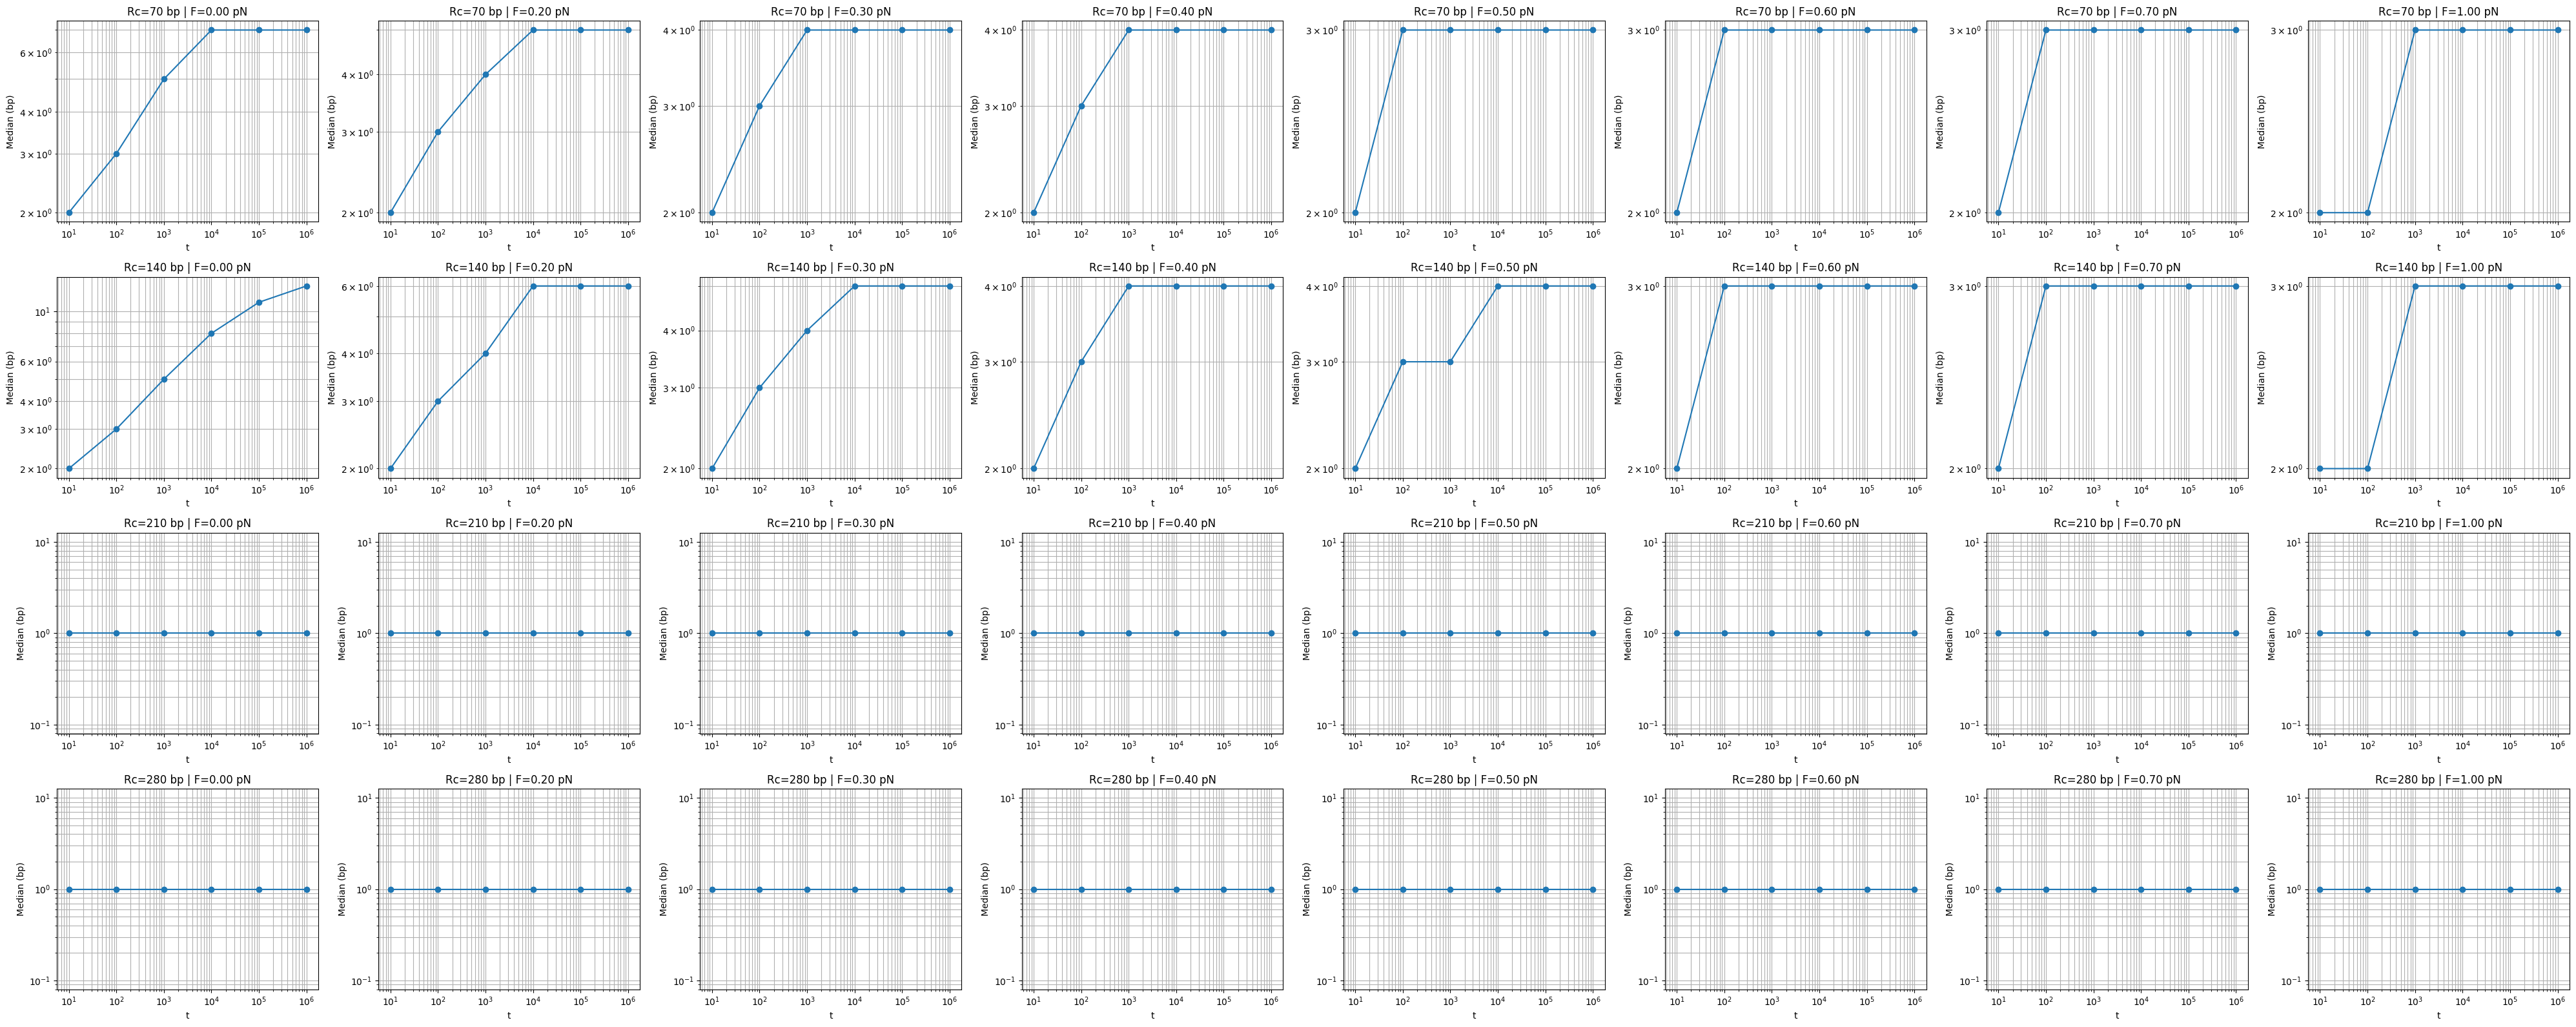

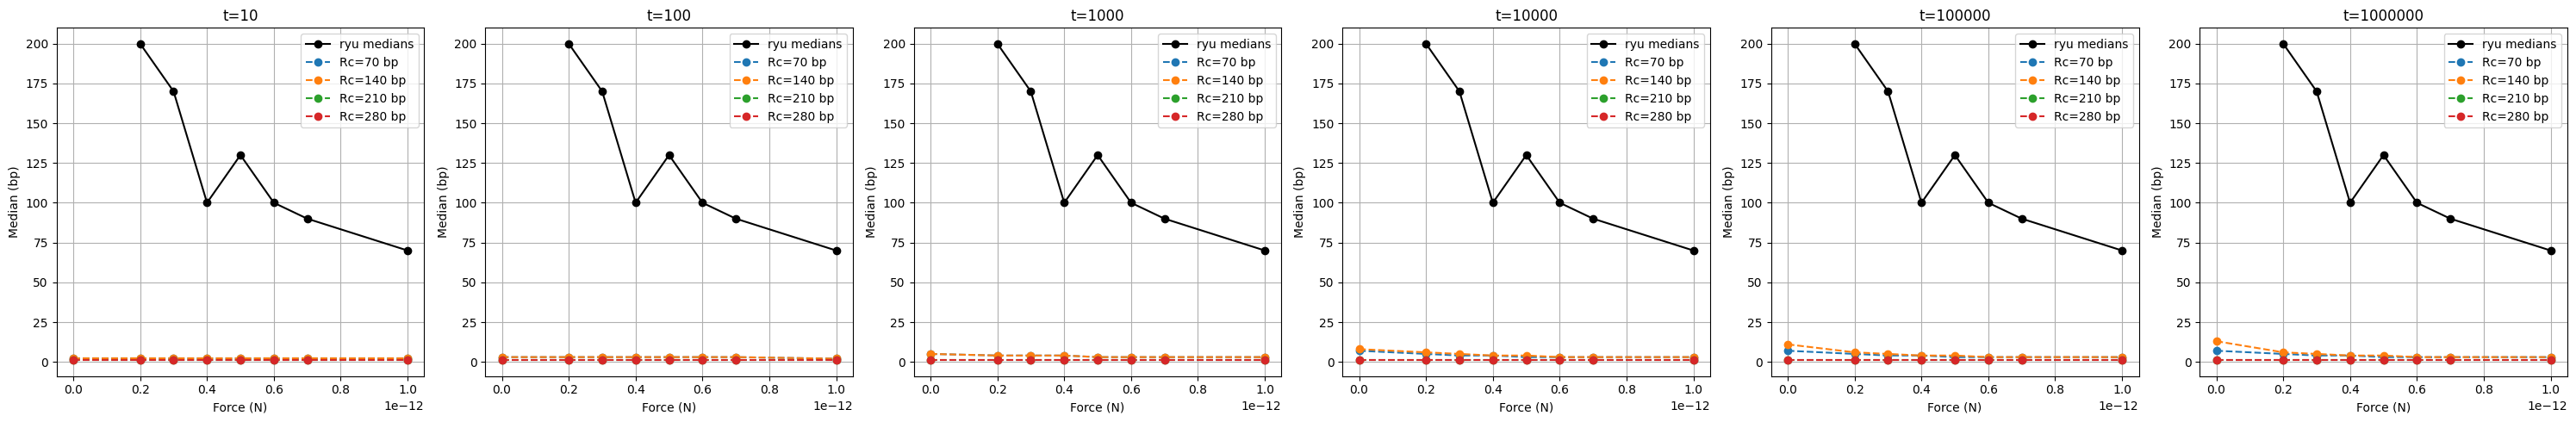

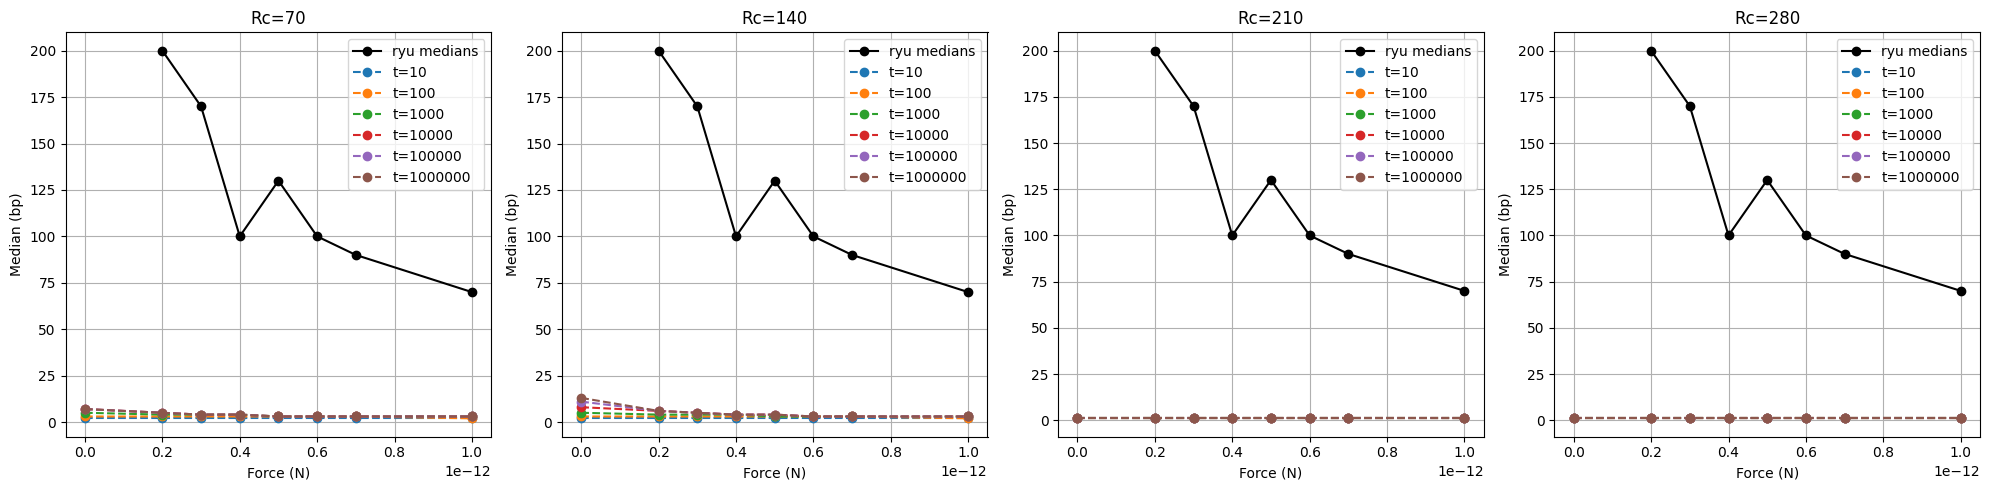

In [11]:
# Reading
df_medians = read_medians_csv("all_medians.csv")

# Pritting
print(df_medians.shape)
print(df_medians.head(5))

# Plotting for camembert
plot_medians_from_df(df_medians, t_array, Rc_max_array, F_bp_array, F_nm_array, ryu_medians=ryu_medians, choice_filter="camembert")

# III. Working Area

Ready to launch run_probas() with parameters:
  lp          = 170
  Rc_max      = 210
  Rc_min      = 0
  Width       = 1
  Theta       = 0
  F_nm        = 4e-13
  conversion  = 2.46e-10
  F_bp        = 0.023756943292610938
  choice_test = camembert


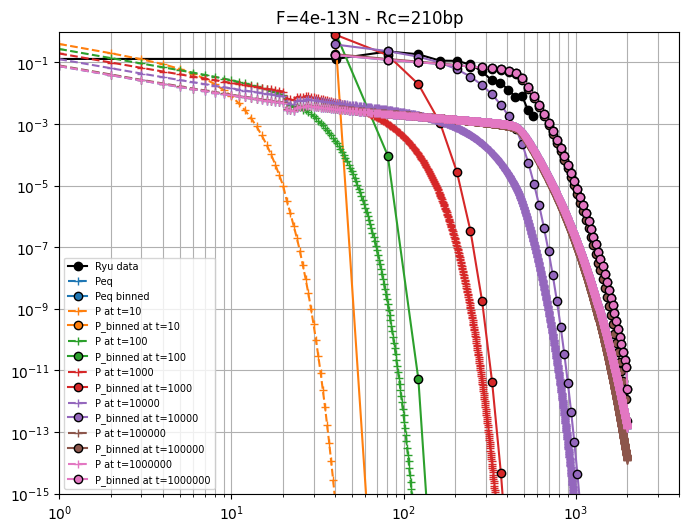

[7.60084184e-02 3.85196090e-02 2.60255736e-02 ... 1.40587311e-13
 1.38625253e-13 1.36690619e-13]
0.9999999999999999


In [154]:
# Print
print("Ready to launch run_probas() with parameters:")
print(f"  lp          = {lp}")
print(f"  Rc_max      = {Rc_max}")
print(f"  Rc_min      = {Rc_min}")
print(f"  Width       = {Width}")
print(f"  Theta       = {Theta}")
print(f"  F_nm        = {F_nm}")
print(f"  conversion  = {conversion}")
print(f"  F_bp        = {F_bp}")
print(f"  choice_test = {choice_test}")

# Getting results to work
Peq, P_points, Peq_summed, P, P_summed, medians = getting_datas(choice_test, lp, Rc_min, Rc_max, F_nm, Width, Theta, conversion, x_array, t_array, x_max, ryu_x, ryu_y, plot_option=True, return_option=True)
print(Peq)
print(np.sum(Peq))

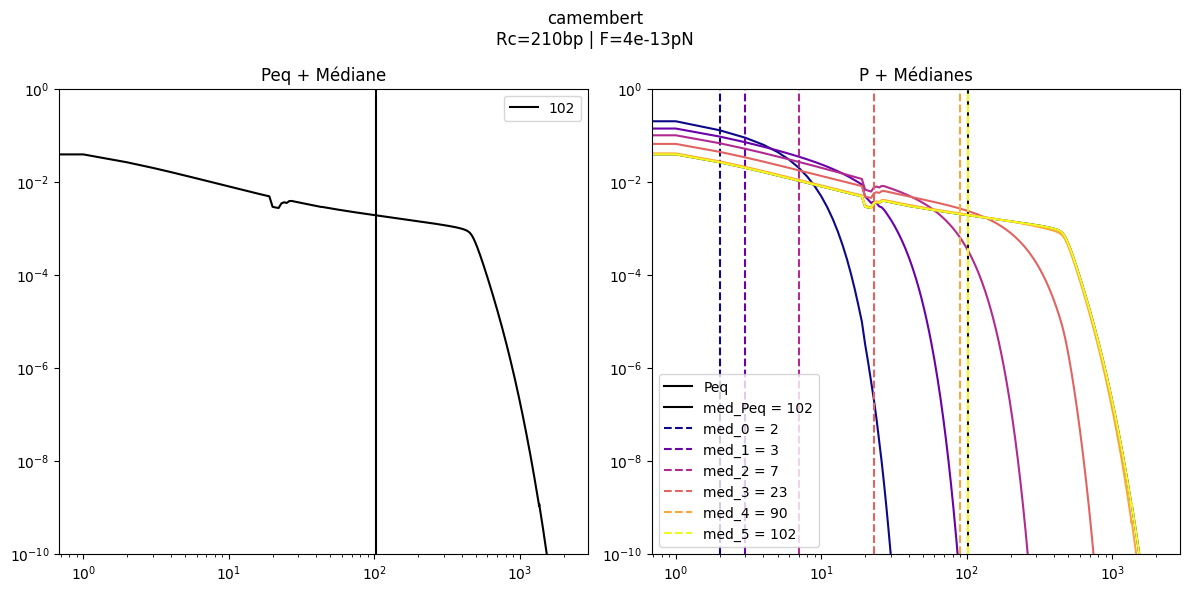

In [155]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle(f"{choice_test}\nRc={Rc_max}bp | F={F_nm}pN")
xbp_test = np.arange(1, len(Peq) + 1)


# Subplot gauche
med_test = find_median(data=Peq.copy(), points=xbp_test)

axes[0].plot(Peq, c='k')
axes[0].axvline(x=med_test, c='k', label=f'{med_test}')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].set_title("Peq + Médiane")
axes[0].set_ylim([1e-10, 1e0])


# Subplot droite
colors = plt.cm.plasma(np.linspace(0, 1, len(P)))
axes[1].plot(Peq, c='k', label="Peq")
axes[1].axvline(x=med_test, c='k', label=f'med_Peq = {med_test}')
for _ in range(len(P)):
    color = colors[_]
    med_test = find_median(data=P[_].copy(), points=xbp_test)

    axes[1].plot(P[_], color=color)
    axes[1].axvline(x=med_test, label=f'med_{_} = {med_test}', ls="--", color=color)
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
    axes[1].legend()
    axes[1].set_title("P + Médianes")
axes[1].set_ylim([1e-10, 1e0])

# Show + Prints
plt.tight_layout()
plt.show()


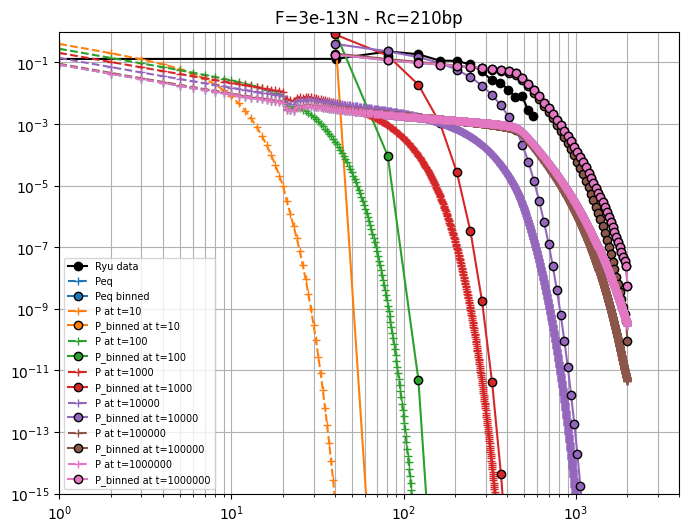

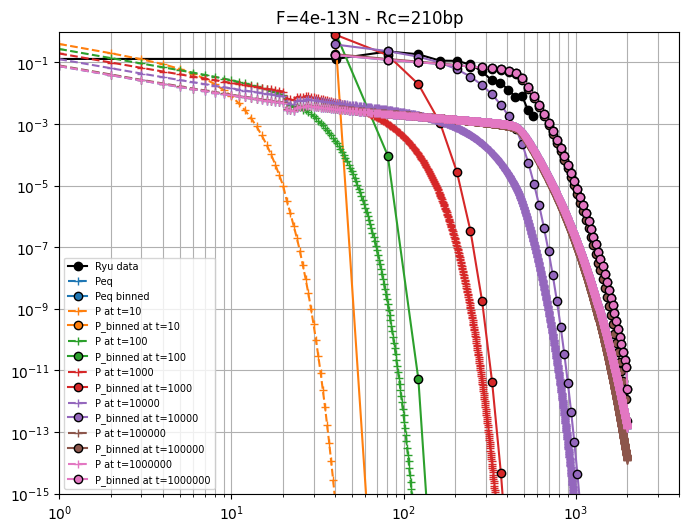

[7.60084184e-02 3.85196090e-02 2.60255736e-02 ... 1.40587311e-13
 1.38625253e-13 1.36690619e-13]
0.9999999999999999


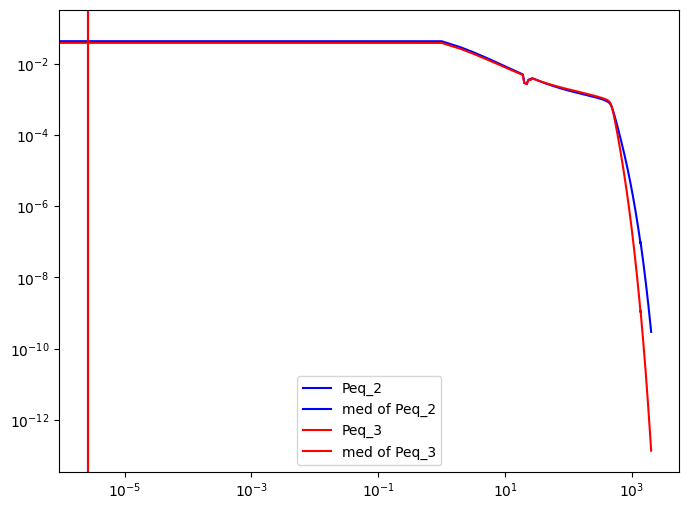

In [160]:
Peq_2, _, _, _, _, _ = getting_datas(choice_test, lp, Rc_min, Rc_max, F_nm_array[2], Width, Theta, bp_per_m_array[2], x_array, t_array, x_max, ryu_x, ryu_y, plot_option=True, return_option=True)
Peq_3, _, _, _, _, _ = getting_datas(choice_test, lp, Rc_min, Rc_max, F_nm_array[3], Width, Theta, bp_per_m_array[3], x_array, t_array, x_max, ryu_x, ryu_y, plot_option=True, return_option=True)

print(Peq)
print(np.sum(Peq))


plt.figure(figsize=(8,6))
plt.plot(Peq_2, label='Peq_2', c='b')
plt.axvline(np.median(Peq_2), label='med of Peq_2', c='b')
plt.plot(Peq_3, label='Peq_3', c='r')
plt.axvline(np.median(Peq_2), label='med of Peq_3', c='r')
plt.legend()
plt.loglog()
plt.show()

# .